## Introduction:

The purpose of this project is to use data science tools to analyze capital bikeshare (cb) usage around 
Washington, DC before and during the COVID-19 ('coronavirus') pandemic to answer questions. Questions that come to mind include:

- What is the total number of rides since 2018?
- What are the highest (peak) and lowest (bottom) demand days/months since 2018? 
- How has total bike shared usage changed before/during COVID-19?
- Is the average ride duration shorter, longer, or the same, compared with before COVID-19?
- What bikeshare locations have the greatest difference in rides before/during COVID-19? Is there a trend/clustering to these locations? 

This brief report is seperated into 5 parts; Intro, Data Input, Data Cleaning/Processing, Data Analysis, Conclusions. See readme file on github [here] (https://github.com/mcgaritym/capital_bikeshare) for additional details.

What is Capital Bikeshare? From the company [site](https://www.capitalbikeshare.com/how-it-works):
>Capital Bikeshare is metro DC's bikeshare service, with 4,500 bikes and 500+ stations across 7 jurisdictions: Washington, DC.; Arlington, VA; Alexandria, VA; Montgomery, MD; Prince George's County, MD; Fairfax County, VA; and the City of Falls Church, VA. Designed for quick trips with convenience in mind, it’s a fun and affordable way to get around.

*Note: The pandemic begin date for this analysis is considered to be **1  Mar 2020**, since that is close to when most cities/towns started enacting protective measures. Since it is ongoing the end date is TBD, however, data is only available through 30 Jun 2020 at this time...*

## Data Input:

Data is provided by Capital Bikeshare [here](https://www.capitalbikeshare.com/system-data) on a monthly basis and provides data on all rides. Data was loaded for all 2018, 2019, and 2020 (through June) months. 


In [115]:
#load required libraries
import requests
import io
from io import BytesIO
from bs4 import BeautifulSoup
import urllib.request
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import datetime
from datetime import date, datetime
import re
import time
from urllib.request import urlopen
import zipfile
from zipfile import ZipFile
import glob
import os
from urllib.request import urlopen, Request
import seaborn as sns
import textwrap
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import folium
from folium import plugins
from folium.plugins import HeatMap
import numpy as np

# gather files in local directory, create empty dataframe, and concatenate data
files = glob.glob('20*')
files.sort()
#print(files)
df = pd.DataFrame()
for f in files:
    data = pd.read_csv(f)
    df = pd.concat([df, data], axis=0, sort='False')

# reindex data 
df = df.reindex()

## Data Cleaning/Processing:

In [116]:
# some files have different columns names, so the below text standardizes/fills columns, converts to datetime(if applicable), and creates new duration or number_rides column
df.reset_index(level=0, inplace=True)
df['start_station_name'].update(df.pop('Start station'))
df['end_station_name'].update(df.pop('End station'))
df['started_at'].update(df.pop('Start date'))
df['ended_at'].update(df.pop('End date'))
df['member_casual'].update(df.pop('Member type'))
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['duration'] = df['ended_at'] - df['started_at']
df['number_rides'] = 1

# drop unnecessary, redundant or blank columns
df = df.drop(columns = ['Duration', 'is_equity', 'rideable_type', 'Bike number', 'start_station_id', 'end_station_id'])

# rename columns
df[['start_lat', 'end_lat', 'start_lng', 'end_lng', 'Start station number', 'End station number']] = df[['start_lat', 'end_lat', 'start_lng', 'end_lng', 'Start station number', 'End station number']].apply(pd.to_numeric)

#convert to category data type
df[['start_station_name', 'end_station_name']] = df[['start_station_name', 'end_station_name']].apply(pd.Categorical)

# filling in missing start and end station numbers and
df['Start station number'] = df['Start station number'].fillna(df.groupby('start_station_name')['Start station number'].transform('mean'))
df['End station number'] = df['End station number'].fillna(df.groupby('end_station_name')['End station number'].transform('mean'))

# fill in missing latitude/longitude data based on other rows (same station) that have latitude/longitude
df['start_lat'] = df['start_lat'].fillna(df.groupby('Start station number')['start_lat'].transform('mean'))
df['end_lat'] = df['end_lat'].fillna(df.groupby('End station number')['end_lat'].transform('mean'))
df['start_lng'] = df['start_lng'].fillna(df.groupby('Start station number')['start_lng'].transform('mean'))
df['end_lng'] = df['end_lng'].fillna(df.groupby('End station number')['end_lng'].transform('mean'))

# rename columns
df = df.rename(columns={'Start station number': 'start_station_id', 'End station number': 'end_station_id'})

#print('Before dropna:', len(df))
# drop rows with missing values
#df = df.dropna(subset=['start_lat', 'end_lat', 'start_lng', 'end_lng', 'start_station_id', 'end_station_id', 'start_station_name', 'end_station_name'])
#print('After dropna:', len(df))

# print sample of data
print('Data Sample: \n')
df.head()

Data Sample: 



,index,end_station_id,start_station_id,end_lat,end_lng,end_station_name,ended_at,member_casual,ride_id,start_lat,start_lng,start_station_name,started_at,duration,number_rides
0,0,31400.0,31104.0,38.936692,-77.024190,Georgia & New Hampshire Ave NW,2018-01-01 00:14:18,Member,NaN,38.922913,-77.042590,Adams Mill & Columbia Rd NW,2018-01-01 00:05:06,00:09:12,1
1,1,31321.0,31321.0,38.892208,-77.033206,15th St & Constitution Ave NW,2018-01-01 00:35:53,Casual,NaN,38.892207,-77.033206,15th St & Constitution Ave NW,2018-01-01 00:14:30,00:21:23,1
2,2,31321.0,31321.0,38.892208,-77.033206,15th St & Constitution Ave NW,2018-01-01 00:35:58,Casual,NaN,38.892207,-77.033206,15th St & Constitution Ave NW,2018-01-01 00:14:53,00:21:05,1
3,3,31103.0,31406.0,38.926093,-77.036520,16th & Harvard St NW,2018-01-01 00:25:09,Casual,NaN,38.942487,-77.032689,14th & Upshur St NW,2018-01-01 00:15:31,00:09:38,1
4,4,31619.0,31618.0,38.890480,-76.988377,Lincoln Park / 13th & East Capitol St NE,2018-01-01 00:24:15,Member,NaN,38.889978,-77.000324,4th & East Capitol St NE,2018-01-01 00:18:02,00:06:13,1


## Data Analysis

The first plot below shows total rides over time until present. The red shaded region indicates the COVID-19 pandemic period of time. 

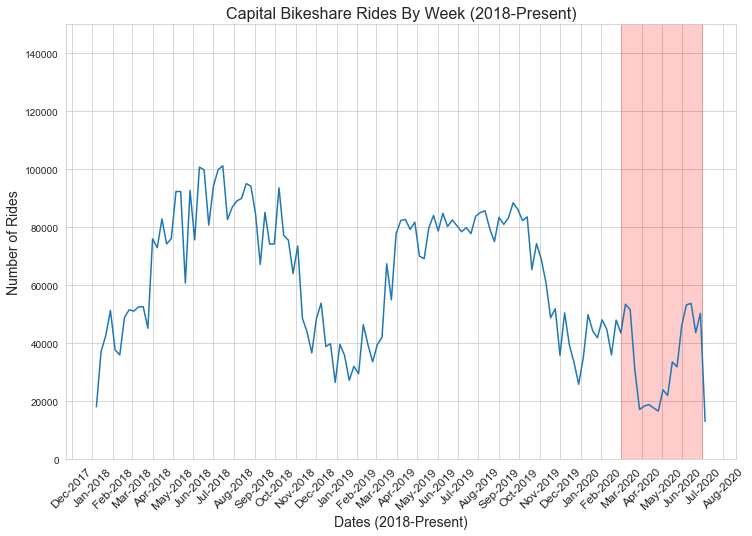

In [117]:
# plot number of rides over time
df.reset_index(level=0, inplace=True)
df['started_at'] = pd.to_datetime(df['started_at'])
df = df.set_index(['started_at'])
df_weekly = df['number_rides'].resample('W').sum()

plt.figure(figsize = (12, 8))
sns.lineplot(x=df_weekly.index, y=df_weekly[:])
plt.title('Capital Bikeshare Rides By Week (2018-Present)', fontsize=16)
plt.ylabel('Number of Rides', fontsize=14)
plt.ylim((0,150000))
plt.xlabel('Dates (2018-Present)', fontsize=14)
plt.xticks(rotation=45, fontsize=12) 
plt.axvspan(datetime(2020,3,1), datetime(2020,6,30), color='red', alpha=0.2)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
sns.set_style("whitegrid")

In [127]:
# Compare total rides, total rides by year (Note: 2020 data until Jun)
#df = df.reset_index()
df['year'] = df['started_at'].apply(lambda x: x.year)
df['month'] = df['started_at'].apply(lambda x: x.month)
print('\n Total number of rides (2018-Present): \n', len(df))
print('\n Three highest ride days (2018-Present): \n', df.set_index(['started_at'])['number_rides'].resample('D').sum().nlargest(3))
print('\n Total number of rides (2018-Present) By Year: \n', df.groupby('year')['number_rides'].sum())



 Total number of rides (2018-Present): 7916731

 Three highest ride days (2018-Present): 
 started_at
2018-04-14    19113
2019-04-06    18346
2019-03-30    17911
Name: number_rides, dtype: int64

 Total number of rides (2018-Present) By Year: 
 year
2018    3542684
2019    3398417
2020     975630
Name: number_rides, dtype: int64

 Total number of rides (Mar-Jun) By Year): 
 year
2018    1334358
2019    1289651
2020     600760
Name: number_rides, dtype: int64
<class 'pandas.core.series.Series'>


/Users/mcgaritym/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


                started_at  level_0  index  end_station_id  start_station_id  \
350968 2018-03-01 00:00:17   350968      0         31642.0           31638.0   
350969 2018-03-01 00:00:19   350969      1         31222.0           31241.0   
350970 2018-03-01 00:00:40   350970      2         31126.0           31503.0   
350971 2018-03-01 00:01:54   350971      3         31289.0           31314.0   
350972 2018-03-01 00:02:40   350972      4         31244.0           31247.0   

          end_lat    end_lng                             end_station_name  \
350968  38.902403 -77.016003                     New Jersey Ave & L St NW   
350969  38.899005 -77.033393                    New York Ave & 15th St NW   
350970  38.925619 -77.027106                          11th & Girard St NW   
350971  38.890522 -77.049390  Henry Bacon Dr & Lincoln Memorial Circle NW   
350972  38.884110 -77.017423                                4th & E St SW   

                  ended_at member_casual ride_id  start_

In [ ]:
# Compare Mar-Jun period of 2020 (total) versus 2018, 2019
#df.reset_index(level=0, inplace=True)
df_grouped = df[(df['started_at'].dt.month >= 3) & (df['started_at'].dt.month <= 6)]
print('\n Total number of rides (Mar-Jun) By Year): \n', df_grouped.groupby('year')['number_rides'].sum())
print(type(df.duration))
df_grouped['duration'] = df_grouped['duration'].apply(lambda x: x.total_seconds() * (1/60))
print(df_grouped.head())
print(type(df_grouped['duration']))
print('\n Average ride time (Mar-Jun) By Year): \n', df_grouped.groupby('year')['duration'].mean())


In [146]:
# Compare Mar-Jun period of 2020 (by station) versus 2018, 2019
# #df_grouped['start_station_name'] = df_grouped['start_station_name'].astype('category')
df_grouped_2 = df_grouped.groupby(['start_station_name', 'year'])['number_rides'].count().unstack()
print('\n', df_grouped_2)

df_grouped_2.columns = df_grouped_2.columns.astype(list)
df_grouped_2.columns = ['2018', '2019', '2020']
df_grouped_2 = df_grouped_2[(df_grouped_2['2019'] != 0) & (df_grouped_2['2020'] != 0)]
# #df_grouped = df_grouped[df_grouped.index.str.contains("Metro")]

df_grouped_2['% Change 2019-2020'] = (df_grouped_2['2020'] - df_grouped_2['2019'])/df_grouped_2['2019'] * 100
#df_grouped_2['% Change 2019-2020'] = df_grouped_2['% Change 2019-2020'].sort_values(ascending=False)
print('\n Top Stations of Ride Growth (Increase): \n', df_grouped_2.sort_values(by ='% Change 2019-2020' , ascending=False)['% Change 2019-2020'].nlargest(10))
print('\n Top Stations of Ride Loss (Decrease): \n', df_grouped_2.sort_values(by ='% Change 2019-2020' , ascending=False)['% Change 2019-2020'].nsmallest(10))

df_growth = df_grouped_2.sort_values(by ='% Change 2019-2020' , ascending=False)['% Change 2019-2020'].nlargest(10)
df_loss = df_grouped_2.sort_values(by ='% Change 2019-2020' , ascending=False)['% Change 2019-2020'].nsmallest(10)

df_growth.columns = df_growth.columns.astype(list)
df_growth['start_lng'] = np.nan
df_growth['start_lng'].reset_index(inplace=True)
df_growth['start_lng'] = df_growth['start_lng'].fillna(df.groupby('start_station_name')['start_lng'].transform('mean'))

print(df_growth.head())



 year                                                2018  2019  2020
start_station_name                                                  
10th & E St NW                                      6020  4128  1530
10th & Florida Ave NW                               3029  3189  1546
10th & G St NW                                      4370  3260   819
10th & K St NW                                      7354  7219  2050
10th & Monroe St NE                                 1101  1264  1035
...                                                  ...   ...   ...
Wisconsin Ave & O St NW                             4189  3387  1529
Woodglen Dr & Executive Blvd                         334   296   348
Woodley Park Metro / Calvert St & Connecticut A...     0  5495  2940
Woodmont Ave & Strathmore St                         868   970   851
Yuma St & Tenley Circle NW                           637   547   156

[691 rows x 3 columns]

 Top Stations of Ride Growth (Increase): 
 start_station_name
Amherst Ave & 

AttributeError: 'Series' object has no attribute 'columns'